In [1]:
# %%
import os
import jax

# 设置环境变量
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'

import netket as nk
import jax
print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())


启用分片模式： True
可用设备： [CudaDevice(id=0), CudaDevice(id=1)]


In [2]:
# %%
import os
import logging
import sys
import jax
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import netket.nn as nknn
import flax
import flax.linen as nn
import jax.numpy as jnp
import math
from math import pi
from functools import partial
from netket.nn import log_cosh
from einops import rearrange
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group
from netket.utils.group import PointGroup, Identity, PermutationGroup
from netket.operator.spin import sigmax, sigmay, sigmaz
from netket.optimizer.qgt import QGTJacobianPyTree, QGTJacobianDense, QGTOnTheFly
from netket.operator import AbstractOperator
from netket.vqs import VariationalState
from scipy import sparse as _sparse
from netket.utils.types import DType as _DType
from netket.hilbert import DiscreteHilbert as _DiscreteHilbert
from netket.operator import LocalOperator as _LocalOperator
from tqdm.notebook import tqdm
from jax import tree

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import math
from einops import rearrange
from netket.nn import log_cosh
from jax._src import dtypes

# 位置编码
class PositionalEncoding(nn.Module):
    """位置编码模块"""
    d_model: int
    max_len: int = 5000
    param_dtype: jnp.dtype = jnp.float64  # 改为实值

    def setup(self):
        # 创建位置编码矩阵
        position = jnp.arange(self.max_len)[:, jnp.newaxis]
        div_term = jnp.exp(jnp.arange(0, self.d_model, 2) * (-math.log(10000.0) / self.d_model))
        pe = jnp.zeros((self.max_len, self.d_model), dtype=self.param_dtype)
        pe = pe.at[:, 0::2].set(jnp.sin(position * div_term))
        pe = pe.at[:, 1::2].set(jnp.cos(position * div_term))
        self.pe = pe

    def __call__(self, x):
        """
        参数:
            x: [batch_size, seq_len, d_model]
        """
        x = x + self.pe[:x.shape[1]]
        return x

# 多头注意力机制
class MultiHeadAttention(nn.Module):
    """多头注意力机制"""
    d_model: int
    heads: int
    param_dtype: jnp.dtype = jnp.float64  # 改为实值

    def setup(self):
        self.head_dim = self.d_model // self.heads
        self.wq = nn.Dense(self.d_model, param_dtype=self.param_dtype, dtype=self.param_dtype)
        self.wk = nn.Dense(self.d_model, param_dtype=self.param_dtype, dtype=self.param_dtype)
        self.wv = nn.Dense(self.d_model, param_dtype=self.param_dtype, dtype=self.param_dtype)
        self.wo = nn.Dense(self.d_model, param_dtype=self.param_dtype, dtype=self.param_dtype)

    def __call__(self, x):
        batch_size, seq_len, _ = x.shape
        
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        
        # 重塑为多头格式
        q = rearrange(q, 'b s (h d) -> b h s d', h=self.heads)
        k = rearrange(k, 'b s (h d) -> b h s d', h=self.heads)
        v = rearrange(v, 'b s (h d) -> b h s d', h=self.heads)
        
        # 计算注意力分数
        attn_scores = jnp.einsum('bhid,bhjd->bhij', q, k) / jnp.sqrt(self.head_dim)
        attention = nn.softmax(attn_scores, axis=-1)
        
        # 应用注意力权重
        out = jnp.einsum('bhij,bhjd->bhid', attention, v)
        out = rearrange(out, 'b h s d -> b s (h d)')
        
        return self.wo(out)

# 前馈神经网络
class MLP(nn.Module):
    """前馈神经网络"""
    d_model: int
    mlp_dim: int
    param_dtype: jnp.dtype = jnp.float64  # 改为实值

    def setup(self):
        self.fc1 = nn.Dense(self.mlp_dim, param_dtype=self.param_dtype, dtype=self.param_dtype)
        self.fc2 = nn.Dense(self.d_model, param_dtype=self.param_dtype, dtype=self.param_dtype)
        self.gelu = lambda x: x * 0.5 * (1.0 + jnp.tanh(jnp.sqrt(2.0 / jnp.pi) * (x + 0.044715 * x**3)))

    def __call__(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x

# Transformer编码器块
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    d_model: int
    heads: int
    mlp_dim: int
    param_dtype: jnp.dtype = jnp.float64  # 改为实值

    def setup(self):
        self.attn = MultiHeadAttention(d_model=self.d_model, heads=self.heads, param_dtype=self.param_dtype)
        self.norm1 = nn.LayerNorm(dtype=self.param_dtype, param_dtype=self.param_dtype)
        self.norm2 = nn.LayerNorm(dtype=self.param_dtype, param_dtype=self.param_dtype)
        self.mlp = MLP(d_model=self.d_model, mlp_dim=self.mlp_dim, param_dtype=self.param_dtype)

    def __call__(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# Transformer编码器
class Encoder(nn.Module):
    """Transformer编码器"""
    num_layers: int
    d_model: int
    heads: int
    mlp_dim: int
    param_dtype: jnp.dtype = jnp.float64  # 改为实值

    def setup(self):
        self.layers = [
            EncoderBlock(
                d_model=self.d_model,
                heads=self.heads,
                mlp_dim=self.mlp_dim,
                param_dtype=self.param_dtype
            ) 
            for _ in range(self.num_layers)
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# 输出头
class OutputHead(nn.Module):
    d_model: int

    def setup(self):
        self.out_layer_norm = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm0 = nn.LayerNorm(use_scale=True, use_bias=True, dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm1 = nn.LayerNorm(use_scale=True, use_bias=True, dtype=jnp.float64, param_dtype=jnp.float64)
        self.output_layer0 = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=jax.nn.initializers.zeros,
                                      param_dtype=jnp.float64, dtype=jnp.float64)
        self.output_layer1 = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=jax.nn.initializers.zeros,
                                      param_dtype=jnp.float64, dtype=jnp.float64)

    def __call__(self, x):
        z = self.out_layer_norm(x.sum(axis=1))
        amp = self.norm0(self.output_layer0(z))
        sign = self.norm1(self.output_layer1(z))
        out = amp + 1j * sign

        return jnp.sum(log_cosh(out), axis=-1)

# ViT量子态模型
class ViTFNQS(nn.Module):
    num_layers: int
    d_model: int
    heads: int
    mlp_dim: int
    patch_size: int
    n_sites: int
    param_dtype: jnp.dtype = jnp.float64  # 改为实值默认

    def setup(self):
        # CLS标记 (实值)
        self.cls_token = self.param(
            'cls_token', 
            nn.initializers.zeros, 
            (1, 1, self.d_model),
            self.param_dtype
        )
        
        # Patch嵌入层 (实值)
        self.patch_embed = nn.Dense(
            self.d_model, 
            param_dtype=self.param_dtype, 
            dtype=self.param_dtype,
            kernel_init=nn.initializers.xavier_uniform()
        )
        
        # 位置编码 (实值)
        self.pos_embedding = PositionalEncoding(d_model=self.d_model, param_dtype=self.param_dtype)
        
        # Transformer编码器 (实值)
        self.encoder = Encoder(
            num_layers=self.num_layers,
            d_model=self.d_model,
            heads=self.heads,
            mlp_dim=self.mlp_dim,
            param_dtype=self.param_dtype
        )
        
        # 输出头 (复值) - 这是唯一使用复值参数的部分
        self.output = OutputHead(
            self.d_model
        )
    
    def extract_patches(self, x, batch_size=None):
        """从输入中提取patch"""
        if batch_size is None:
            batch_size = x.shape[0]
            
        # 重塑为patch
        if self.patch_size > 1:
            # 将邻居聚集为patch
            x = rearrange(
                x, 
                'b (n p) -> b n p', 
                p=self.patch_size
            )
        else:
            # 如果patch_size=1，每个site作为一个独立patch
            x = x.reshape(batch_size, self.n_sites, 1)
            
        return x

    def __call__(self, x):
        batch_size = x.shape[0]
        
        # 提取patch
        x = self.extract_patches(x, batch_size)
        
        # 嵌入patch
        x = self.patch_embed(x)
        
        # 添加CLS标记
        cls_tokens = jnp.repeat(self.cls_token, batch_size, axis=0)
        x = jnp.concatenate([cls_tokens, x], axis=1)
        
        # 添加位置编码
        x = self.pos_embedding(x)
        
        # 通过编码器
        x = self.encoder(x)
        
        # 通过输出头
        out = self.output(x)
        
        return out

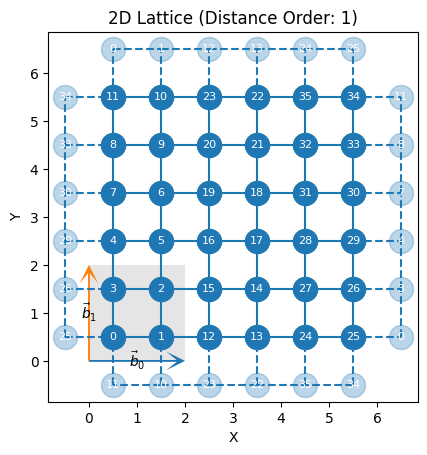

哈密顿量构建完成，J1=0.8, J2=1.0, Q=0


In [4]:
# %%
# 哈密顿量参数
J1 = 0.8
J2 = 1.0
Q = 0  # 四自旋相互作用强度，替换h项

# Shastry-Sutherland晶格定义
Lx = 3
Ly = 3

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

# %%
# Hilbert空间定义
hi = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# Q项需要的C_ij算子定义
Cij = 0.25 * umum - SiSj
Cij2 = np.kron(Cij, Cij)  # 四自旋交互项

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hi, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hi, dtype=jnp.complex128)

# 添加四自旋Q项 - 每个单元格(plaquette)上的四自旋相互作用
for unit_x in range(Lx):
    for unit_y in range(Ly):
        # 找到单元格中的4个顶点
        base_idx = 4 * (unit_x + unit_y * Lx)
        plaq_sites = [
            base_idx,                  # 左下角 (0.5, 0.5) 
            base_idx + 1,              # 右下角 (1.5, 0.5)
            base_idx + 2,              # 右上角 (1.5, 1.5)
            base_idx + 3               # 左上角 (0.5, 1.5)
        ]
        
        # 两种不同的顺序添加四自旋相互作用Q项
        # 按照顺时针方向连接
        sites_clockwise = [plaq_sites]
        operatorQ = [(-Q * Cij2).tolist()]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_clockwise)
        
        # 按照交叉方向连接
        sites_cross = [[plaq_sites[0], plaq_sites[2], plaq_sites[1], plaq_sites[3]]]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_cross)

# 合并两部分哈密顿量
ha = H_J + H_Q
ha = ha.to_jax_operator()

print(f"哈密顿量构建完成，J1={J1}, J2={J2}, Q={Q}")

In [5]:
# %%
N_layers =  4         # 编码器层数
d_model = 48          # 特征维度
n_heads = 12           # 注意力头数
mlp_dim = d_model*2     # MLP维度
patch_size = 2        # patch大小
n_samples = 2**12     # 样本数量
chunk_size = 2**8    # 批处理大小

# 创建未对称化的ViT量子态模型
model_no_symm = ViTFNQS(
    num_layers=N_layers,
    d_model=d_model,
    mlp_dim=mlp_dim,
    heads=n_heads,
    n_sites=lattice.n_nodes,
    patch_size=patch_size
    )


nc = 4
cyclic_4 = PointGroup(
    [Identity()] + [rotation((360 / nc) * i) for i in range(1, nc)],
    ndim=2,
)

C4v = glide_group(trans=(1, 1), origin=(0, 0)) @ cyclic_4
symmetries = lattice.space_group(C4v)
print(f"对称性操作数量: {len(symmetries)}")


# 使用SymmExpSum对模型进行对称化
from netket.nn.blocks import SymmExpSum
model = SymmExpSum(
    module=model_no_symm, 
    symm_group=symmetries, 
    character_id=None
)

对称性操作数量: 72


In [6]:
import netket.optimizer as nk_opt

sampler = nk.sampler.MetropolisExchange(hilbert=hi, graph=lattice, n_chains=n_samples, d_max=2)
optimizer = nk_opt.Sgd(learning_rate=0.05)

In [7]:
# %%
from netket.experimental.driver.vmc_srt import VMC_SRt
from netket.callbacks import EarlyStopping


# 初始化变分量子态
vqs = nk.vqs.MCState(
    sampler=sampler,
    model=model,
    n_samples=n_samples,
    n_samples_per_rank=None,
    n_discard_per_chain=0,
    chunk_size=chunk_size,
    training_kwargs={"holomorphic": False}  # 非全纯函数
)

n_params = nk.jax.tree_size(vqs.parameters)
print(f"模型参数数量: {n_params}")

模型参数数量: 81024


In [ ]:
import time
import jax
import jax.numpy as jnp
from jax import tree_util
from tqdm.notebook import tqdm
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples
        
        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)
        
        # 自由能梯度：能量梯度减去熵梯度
        total_grad = tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)
        
        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state

# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"Lx={Lx}, Ly={Ly}")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0) / 2.0)
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self


temperature_original = 1.0  # 初始温度
reference_energy = -16.2618

vmc = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=temperature_original,
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=0.01,
    variational_state=vqs
)

start = time.time()
vmc.run(n_iter=1000)
end = time.time()
print(f"优化耗时: {end - start:.2f}秒")
# Lx=3, Ly=3: 100% 1000/1000 [24:22<00:00, 1.46s/it, Temp=0.0000, Energy=-14.404755+0.002588j, E_var=3.695185, E_err=0.030036, Rel_err(%)=11.4197]

Lx=3, Ly=3:   0%|          | 0/1000 [00:00<?, ?it/s]

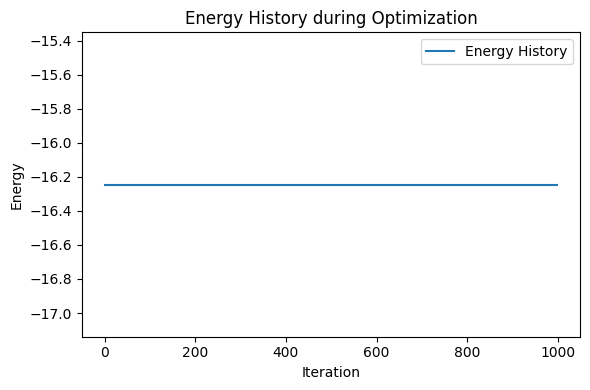

In [ ]:
import pickle
import numpy as np

# 假设在每次迭代中，你已通过如下方式记录能量（例如在 CustomFreeEnergyVMC_SRt.run 中添加）：
# 在 run 的每次迭代末尾加入：
#    energy_history.append(np.real(self.energy.mean))
# 这里提供一个示例来模拟能量历史记录：
energy_history = []  # 记录能量（列表形式）
# 示例：假设在训练循环外部，遍历所有保存的能量（你也可以在 run 方法中直接保存）
for i in range(1000):
    # 每次迭代后记录能量，实际能量可由 vmc.energy.mean 给出
    energy_history.append(np.real(vmc.energy.mean))

# 构造需要保存的信息字典
save_data = {
    "energy_history": energy_history,         # Energy history (x-axis: Iteration, y-axis: Energy)
    "final_parameters": vqs.parameters,         # Final variational state parameters
    "final_energy": np.real(vmc.energy.mean),     # Final average energy value
}

# 将数据保存为 pickle 文件
with open("results.pkl", "wb") as f:
    pickle.dump(save_data, f)

# 如需绘制能量历史图（标注均采用英文），可使用如下代码：
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(energy_history, label="Energy History")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy History during Optimization")
plt.legend()
plt.tight_layout()
plt.savefig("energy_history.png")
plt.show()
